In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import torch
import matplotlib.pyplot as plt
from collections import Counter

from orthogonal_dfa.l_star.examples.bernoulli_parity import BernoulliParityOracle
from orthogonal_dfa.l_star.structures import DecisionTreeLeafNode
from orthogonal_dfa.l_star.sampler import UniformSampler
from orthogonal_dfa.l_star.decision_tree_to_dfa import *
from orthogonal_dfa.utils.pdfa import batched_iterated_matrix_multiply

In [4]:
oracle = BernoulliParityOracle(0.6, 0, modulo=9, allowed_moduluses=(3, 6))

In [5]:
us = UniformSampler(40)

In [6]:
pst = PrefixSuffixTracker.create(
    us,
    np.random.default_rng(0),
    oracle,
    alphabet_size=2,
    num_prefixes=10_000,
    suffix_family_size=30,
    chi_squared_p_min=0.005,
    evidence_thresh=0.55,
    suffix_prevalence=0.05,
)
# dt = pst.extract_decision_tree()

In [7]:
_, _, v_idx = pst.record_suffix([])
vs = [v_idx]

In [8]:
pst.finish_populating_suffix_family(vs)

Completing suffix family:   3%|3         | 1/29 [00:04<02:06,  4.53s/it]

In [9]:
# decision = pst.compute_decision(vs, subset_mask)

In [10]:
# (decision > pst.evidence_thresh).sum(), (decision < 1 - pst.evidence_thresh).sum()

In [11]:
min_state_size = 0.05

In [12]:
vs_queue = [([], vs)]
states = [([], np.ones(len(pst.prefixes), bool))]


def split_with(state_indices, vs):
    states_to_split = [states.pop(i) for i in reversed(sorted(state_indices))]
    for decision, m2 in states_to_split:
        states.extend(pst.split_states(vs, decision, m2))


while vs_queue:
    path, vs_current = vs_queue.pop()
    print(f"Num states: {len(states)}; processing {path}")
    ol = overlaps(pst, states, vs_current, min_state_size=min_state_size)
    if not ol:
        print("Done")
        continue
    split_with(ol, vs_current)
    vs_queue.extend(
        ([c] + path, pst.prepend_to_all(vs_current, c))
        for c in range(pst.alphabet_size)
    )

# split_with([0], vs)
# split_with([0, 1], vs_with_1)

Num states: 1; processing []


Prepending to all suffixes:  17%|#6        | 5/30 [00:01<00:06,  4.04it/s]

Prepending to all suffixes:  17%|#6        | 5/30 [00:01<00:06,  4.09it/s]

Num states: 2; processing [1]


Prepending to all suffixes:  17%|#6        | 5/30 [00:01<00:06,  4.05it/s]

Prepending to all suffixes:  17%|#6        | 5/30 [00:01<00:06,  3.98it/s]

Num states: 3; processing [1, 1]


Prepending to all suffixes:  13%|#3        | 4/30 [00:01<00:06,  3.99it/s]

Prepending to all suffixes:  17%|#6        | 5/30 [00:01<00:06,  4.00it/s]

Num states: 4; processing [1, 1, 1]


Prepending to all suffixes:  17%|#6        | 5/30 [00:01<00:06,  3.98it/s]

Prepending to all suffixes:  17%|#6        | 5/30 [00:01<00:06,  4.00it/s]

Num states: 6; processing [1, 1, 1, 1]


Prepending to all suffixes:  13%|#3        | 4/30 [00:01<00:06,  3.99it/s]

Prepending to all suffixes:  17%|#6        | 5/30 [00:01<00:06,  3.94it/s]

Num states: 8; processing [1, 1, 1, 1, 1]


Prepending to all suffixes:  13%|#3        | 4/30 [00:01<00:06,  3.97it/s]

Prepending to all suffixes:  13%|#3        | 4/30 [00:01<00:06,  3.99it/s]

Num states: 9; processing [1, 1, 1, 1, 1, 1]


Prepending to all suffixes:  13%|#3        | 4/30 [00:01<00:06,  3.94it/s]

Prepending to all suffixes:  13%|#3        | 4/30 [00:01<00:06,  3.94it/s]

Num states: 10; processing [1, 1, 1, 1, 1, 1, 1]
Done
Num states: 10; processing [0, 1, 1, 1, 1, 1, 1]
Done
Num states: 10; processing [0, 1, 1, 1, 1, 1]
Done
Num states: 10; processing [0, 1, 1, 1, 1]
Done
Num states: 10; processing [0, 1, 1, 1]
Done
Num states: 10; processing [0, 1, 1]
Done
Num states: 10; processing [0, 1]
Done
Num states: 10; processing [0]
Done


In [13]:
fdt = [x for x, _ in states]

In [14]:
# [Counter(sum(x) % oracle.modulo for x in p.vs) for p, _ in fdt]

Best DFA has success rate on 'correct' states 0.8850


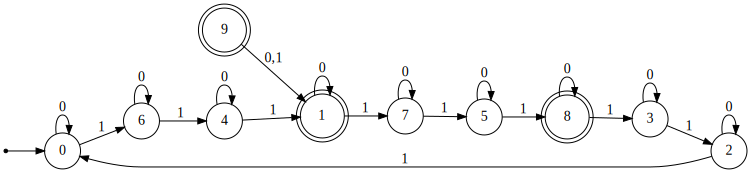

In [15]:
pst.optimal_dfa(fdt)